## Entrenamiento del modelo para el proyecto de Segmentación de Clientes para Campañas Personalizadas.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score, completeness_score
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/4f/ts7gk_kd60q4j4k_6hmrs9_r0000gp/T/ipykernel_85617/2141977928.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
X_train = pd.read_csv('bank_X_train.csv')
y_train = pd.read_csv('bank_y_train.csv')

- Luego de la primera iteracion de entrenamiento con el modelo decidi quitar las  columnas de "season" ya que se persivio que generaban mas ruido. Al volver a hacer el entrenamiento las metricas de evalucion mejoraron un poco.    

In [3]:
X_train = X_train.drop(columns=['season_autumn','season_spring','season_summer','season_winter'])

In [4]:
# Seleccionar las características relevantes para el clustering
features = ['job_category_out_laboral', 'job_category_profesional', 'job_category_t_manuales', 'job_category_unknown','marital_divorced','marital_married','marital_single','education_primary','education_secondary','education_tertiary','education_unknown','default_encoded','housing_encoded','loan_encoded','balance_scaled']
X_train_clustering = X_train[features]

# Entrenar el modelo de K-Means con un número de clusters (k) especificado
k = 2 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_clustering)

# Obtener las etiquetas de los clusters para cada muestra
X_train['cluster'] = kmeans.labels_

In [5]:
X_train['cluster'].unique()

array([1, 0], dtype=int32)

In [6]:
# Evaluar el modelo de clustering (usando silhouette score)
silhouette_avg = silhouette_score(X_train_clustering, kmeans.labels_)
print(f"Silhouette Score para {k} clusters: {silhouette_avg:.4f}")

Silhouette Score para 2 clusters: 0.3261


In [7]:
# Distancia intra-clúster (Inercia)
inertia = kmeans.inertia_
print(f"Distancia intra-clúster (Inercia): {inertia:.4f}")

Distancia intra-clúster (Inercia): 18633.7510


In [8]:
# Ver la distribución de muestras por cluster
print("Distribución de muestras por cluster:")
print(X_train['cluster'].value_counts())

Distribución de muestras por cluster:
cluster
1    6406
0    1407
Name: count, dtype: int64


Luego del entrenamiento se obtuvieron los siguientes parametros de la evaluacion del performance del modelo

- Silhouette Score para 2 clusters: 0.3261
Sugiere que los clusters están separados, pero no de manera muy fuerte. Esto podría ser aceptable para un problema como la segmentación de clientes, aunque deja espacio para mejorar el modelo.
  
- Distancia intra-clúster (Inercia): 18633.7510
Refleja la compacidad de los clusters, aunque el valor no es extremadamente bajo, indica que los datos dentro de cada grupo están razonablemente cerca del centroide correspondiente.
  
- Distribución de muestras por cluster:

- Cluster 1: 6,406 muestras (82%).
- Cluster 0: 1,407 muestras (18%).

Hay un desbalance en el tamaño de los clusters. Esto puede ser normal si los datos tienen estructuras naturales desiguales (por ejemplo, un grupo más grande de clientes con comportamientos similares y un grupo más pequeño con características especiales).
Ya que el objetivo es personalizar campañas, esto puede ser clave para diseñar estrategias de marketing diferenciadas.

### Probando diferentes valores de k

Luego de hacer las dos primeros entrenemaientos del modelo con K= 3 y 2, se decidio usar la tecnica del codo y el Silhouette Score para verificar si exitia algun otro valor de K que fuera el mas optimo para el entrenamiento. Sin embargo las dos graficas mostraron que el mejor valor de k=2.    

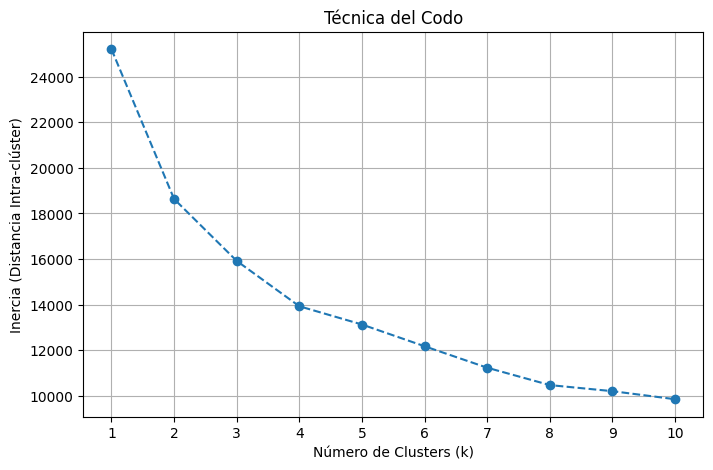

In [9]:
inertia_values = []
k_values = range(1, 11)  # Probar entre 1 y 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_clustering)
    inertia_values.append(kmeans.inertia_)

# Graficar la técnica del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.title('Técnica del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Distancia Intra-clúster)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Silhouette Score para diferentes valores de 𝑘

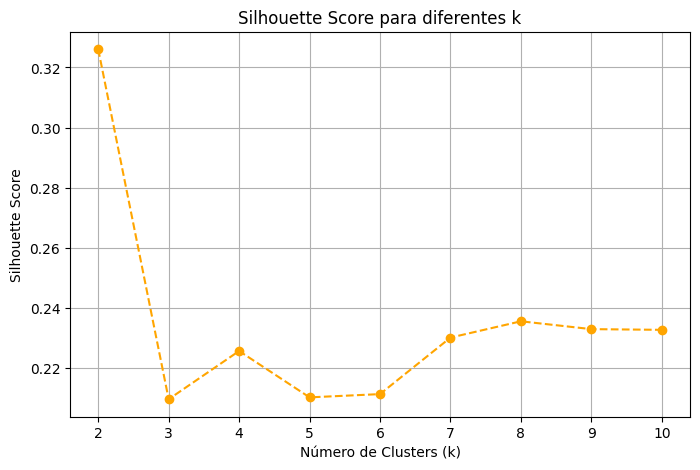

In [10]:
silhouette_scores = []

for k in range(2, 11):  # Silhouette no tiene sentido con k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_clustering)
    silhouette_scores.append(silhouette_score(X_train_clustering, kmeans.labels_))

# Graficar el Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score para diferentes k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


### Visualizar los clusters

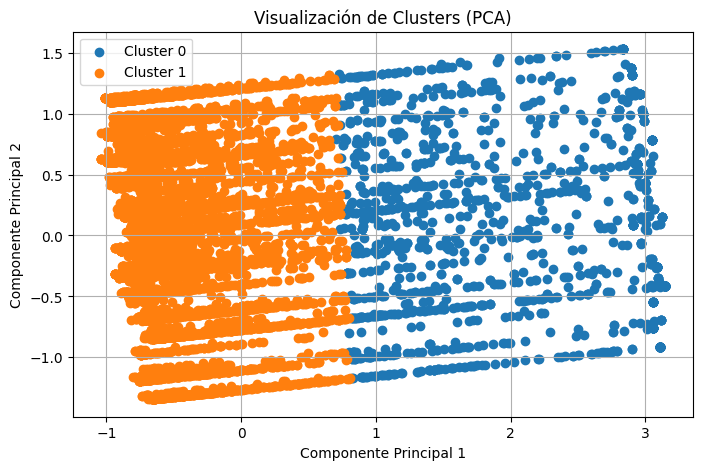

In [11]:
# Reducir las dimensiones a 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_clustering)

# Visualizar los clusters
plt.figure(figsize=(8, 5))
for cluster in range(2):  # Cambiar al número óptimo de clusters
    cluster_data = X_train_pca[X_train['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')
    
plt.title('Visualización de Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
print(y_train.head())
unique_values = y_train['deposit_encoded'].unique()
print(unique_values)

   deposit_encoded
0                0
1                1
2                1
3                1
4                1
[0 1]


In [13]:
# Unir ambos datasets por el índice para tener 'deposit' en el mismo dataframe
train_data = X_train.copy()
train_data['deposit'] = y_train  # Añadir la variable objetivo 

In [14]:
#train_data.info()

In [15]:
unique_values1 = train_data['cluster'].unique()
print(unique_values1)

[1 0]


In [16]:
train_data['cluster'].unique()

array([1, 0], dtype=int32)

In [17]:
unique_clusters = train_data['cluster'].unique()
print(f"Clusters únicos: {unique_clusters}")
print(f"Número total de clusters únicos: {len(unique_clusters)}")

Clusters únicos: [1 0]
Número total de clusters únicos: 2


In [18]:
# Mostrar la distribución de la variable 'deposit' dentro de cada cluster
cluster_deposit_distribution = train_data.groupby('cluster')['deposit'].value_counts(normalize=True)

# Imprimir la distribución de la variable objetivo por cada cluster
print(cluster_deposit_distribution)

cluster  deposit
0        1          0.594172
         0          0.405828
1        0          0.552607
         1          0.447393
Name: proportion, dtype: float64


- Cluster 0:

59.4% (0.594172) de los clientes tienen deposit = 1 (hicieron un depósito).
40.6% (0.405828) de los clientes tienen deposit = 0 (no hicieron un depósito).

En este grupo, hay una mayor proporción de clientes que realizaron un depósito. Esto indica que este cluster agrupa a clientes con mayor probabilidad de realizar un depósito. Podría ser interesante analizar las características predominantes de este cluster para identificar qué tipo de clientes son más propensos a realizar depósitos.

- Cluster 1:

55.3% (0.552607) de los clientes tienen deposit = 0 (no hicieron un depósito).
44.7% (0.447393) de los clientes tienen deposit = 1 (hicieron un depósito).

En este grupo, la mayoría de los clientes no realizaron un depósito. Este cluster agrupa a clientes con menor probabilidad de realizar un depósito. Nuevamente, sería útil explorar las características predominantes de este cluster para entender por qué tienen una menor propensión a realizar depósitos.

### Prueba Algoritmos de Clustering Alternativos

Debido a que los resultados no eran muy satisfactorios se procedio a probar otro algoritmo de clustering, el DBSCAN. Es un algoritmo útil para datos con formas no esféricas o con ruido.

In [19]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train_clustering)
silhouette_dbscan = silhouette_score(X_train_clustering, dbscan_labels)
print(f'Silhouette Score DBSCAN: {silhouette_dbscan:.4f}')

Silhouette Score DBSCAN: 0.2970


Este Silhouette Score es moderadamente bajo, lo que significa que los clusters no están perfectamente definidos o separados. Aunque hay cierta separación entre ellos, podría haber datos ambiguos que están cerca de los límites entre clusters o que no se agrupan bien.

In [20]:
print(type(X_train_clustering))
print(X_train_clustering.shape)

<class 'pandas.core.frame.DataFrame'>
(7813, 15)


In [21]:
print(set(dbscan.labels_))  # Ver los clusters detectados (debe incluir valores como 0, 1, ... o -1 para ruido)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, -1}


In [22]:
# Agregar etiquetas de los clusters al dataset
#train_data['cluster'] = dbscan.labels_

# Filtrar los puntos que no son ruido (ruido tiene etiqueta -1)
#train_data_filtered = train_data[train_data['cluster'] != -1]

In [23]:
#print(train_data['cluster'])

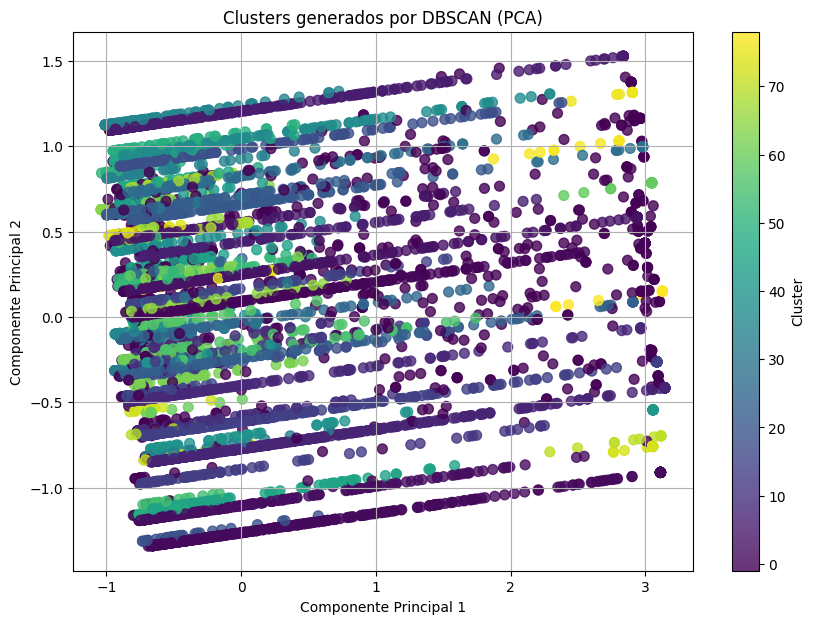

In [24]:
# Reducir las dimensiones a 2 componentes principales usando PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_clustering)

# Crear la visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=dbscan.labels_, cmap='viridis', s=50, alpha=0.8)

# Añadir leyenda de clusters
plt.colorbar(scatter, label="Cluster")
plt.title("Clusters generados por DBSCAN (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()

In [25]:
explained_variance = pca.explained_variance_ratio_
print(f"Proporción de varianza explicada por las dos primeras componentes principales: {explained_variance.sum():.4f}")

Proporción de varianza explicada por las dos primeras componentes principales: 0.5109


Ya que con el DBSCAN no se veia una diferencia significativa para continuar, se dejo de lado y se continuo con los datos obtenidos con el K-means. 

### Métricas Basadas en la Variable Objetivo

Aqui se decidio revisar algunas metricas teniendo en cuenta la variable objetivo para entender un poco mejor los datos de los clusters, por ejemplo:
### Precision
- Cluster 0 (Etiqueta 0): Precisión: 0.41. Esto significa que, de todos los clientes clasificados como "no realizan depósitos", solo el 41% fueron clasificados correctamente.
- Cluster 1 (Etiqueta 1): Precisión = 0.45. De todos los clientes clasificados como "realizan depósitos", el 45% fueron clasificados correctamente.
La precisión en ambos clusters es relativamente baja, indicando que el modelo tiene dificultades para identificar correctamente a los clientes en su categoría asignada.

### Recall (Sensibilidad)
- Cluster 0 (Etiqueta 0): Recall = 0.14. Esto implica que solo el 14% de los clientes que realmente no realizan depósitos fueron correctamente identificados como tales.
- Cluster 1 (Etiqueta 1): Recall = 0.77. Un 77% de los clientes que efectivamente realizan depósitos fueron correctamente identificados.
El modelo es mucho mejor reconociendo a los clientes que realizan depósitos, pero tiene un desempeño muy bajo al identificar a los que no lo hacen.

### f1-score (combina precisión y recall en una sola métrica)
- Cluster 0 (Etiqueta 0): F1-Score = 0.21, lo que muestra que el modelo tiene un desempeño muy pobre en esta clase.
- Cluster 1 (Etiqueta 1): F1-Score = 0.57, mejor que para el cluster 0, pero todavía no es excelente.
El desequilibrio entre las clases (mayor recall para la clase 1) genera un desempeño aceptable para esta clase, pero las predicciones sobre la clase 0 siguen siendo deficientes.

### Macro Avg (Promedio macro)
Este promedio da igual peso a ambas clases, independientemente de la cantidad de muestras en cada una. El modelo, en general, no logra un buen equilibrio entre las dos clases.
Precision: 0.43
Recall: 0.46
F1-Score: 0.39
 
### Weighted Avg (Promedio ponderado)
Este promedio toma en cuenta la cantidad de datos en cada clase. Similar al macro promedio, pero refleja un sesgo hacia la clase 1 debido a su mejor desempeño.
Precision: 0.43
Recall: 0.44
F1-Score: 0.38

In [26]:
print(classification_report(train_data['deposit'], train_data['cluster']))

              precision    recall  f1-score   support

           0       0.41      0.14      0.21      4111
           1       0.45      0.77      0.57      3702

    accuracy                           0.44      7813
   macro avg       0.43      0.46      0.39      7813
weighted avg       0.43      0.44      0.38      7813



Tambien revise la Homogeneidad y Completitud para medir qué tan consistentes son los clusters respecto a la variable objetivo.

In [27]:
homogeneity = homogeneity_score(train_data['deposit'], train_data['cluster'])
completeness = completeness_score(train_data['deposit'], train_data['cluster'])
print(f'Homogeneidad: {homogeneity:.4f}, Completitud: {completeness:.4f}')

Homogeneidad: 0.0092, Completitud: 0.0135


- Un valor tan bajo (0.0092) indica que los clusters generados contienen una mezcla significativa de clientes de ambas categorías de la variable objetivo. Esto sugiere que el modelo no logró separar correctamente a los clientes en grupos homogéneos en función de si realizan o no depósitos.

- Un valor bajo (0.0135) indica que los clientes de una misma categoría están dispersos entre diferentes clusters. Esto implica que el modelo de clustering no logró agrupar eficazmente a los clientes con características similares en relación con su probabilidad de realizar depósitos.

### Promedio de las Variables por Cluster

In [28]:
cluster_summary = train_data.groupby('cluster').mean()
print(cluster_summary)

         job_category_out_laboral  job_category_profesional  \
cluster                                                       
0                        0.169154                  0.618337   
1                        0.123946                  0.571495   

         job_category_t_manuales  job_category_unknown  marital_divorced  \
cluster                                                                    
0                       0.205402              0.007107          0.113717   
1                       0.298626              0.005932          0.115204   

         marital_married  marital_single  education_primary  \
cluster                                                       
0               0.602701        0.283582           0.140725   
1               0.562910        0.321886           0.132376   

         education_secondary  education_tertiary  education_unknown  \
cluster                                                               
0                   0.382374            0.42288

Ahora analizo las variables en cada cluster, 

### Cluster 0 (59.4% realizan depósitos)

Trabajo (job_category):
- Profesionales: El 61.8% de los clientes en este cluster tienen ocupaciones profesionales, lo que indica un perfil socioeconómico más elevado.
- Trabajos manuales: Solo el 20.5% pertenecen a esta categoría, menos que en el Cluster 1.
- Fuera del mercado laboral (jubilados, estudiantes, desempleados): Representan el 16.9%, lo que es mayor que en el Cluster 1.

Estado civil (marital):
- Casados: La mayoría (60.3%) están casados.
- Solteros: Solo el 28.3% son solteros, menos que en el Cluster 1.

Educación:
- Tercera educación (universitaria): 42.3% tienen educación terciaria, significativamente mayor que en el Cluster 1.
- Educación secundaria: Representan el 38.2%, menos que en el Cluster 1.
- Primaria o desconocida: En conjunto, estos valores son bajos, lo que indica un nivel educativo generalmente más alto.

Características financieras:
- Balance promedio: Este cluster tiene un balance promedio mucho más alto (2.39), lo que indica una mayor capacidad económica.

Préstamos y deudas:
- Default: Apenas el 0.07% tienen historial de no pagos, lo que refuerza la estabilidad financiera.
- Préstamos de vivienda: 39.4% tienen hipotecas, menos que en el Cluster 1.
- Préstamos personales: Solo el 5.1% tienen préstamos personales, significativamente menor que en el Cluster 1.

Depósitos:
Casi el 59.4% realizan depósitos, lo que indica una mayor propensión a participar en campañas de ahorro.

### Cluster 1 (44.7% realizan depósitos)

Trabajo (job_category):
- Trabajos manuales: El 29.8% de los clientes tienen trabajos manuales, significativamente mayor que en el Cluster 0.
- Profesionales: Solo el 57.1% están en ocupaciones profesionales, menos que en el Cluster 0.
- Fuera del mercado laboral: Apenas el 12.3%, lo que es menor en comparación con el Cluster 0.

Estado civil (marital):
- Solteros: Un mayor porcentaje (32.1%) de solteros en este cluster.
- Casados: Menor proporción (56.2%) de casados, comparado con el Cluster 0.

Educación:
- Secundaria: Representan el 51.2%, un porcentaje significativamente mayor que en el Cluster 0.
- Tercera educación: Solo el 30.9%, menor en comparación con el Cluster 0.
- Primaria o desconocida: Ligeramente más alto que en el Cluster 0.

Características financieras:
- Balance promedio: Balance considerablemente más bajo (0.0176), lo que indica una capacidad económica limitada.
  
Préstamos y deudas:
- Default: Un 1.8% tienen historial de no pagos, lo que refleja mayor riesgo financiero.
- Préstamos de vivienda: Mayor proporción (49%) tienen hipotecas.
- Préstamos personales: El 14.5% tienen préstamos personales, casi el triple que en el Cluster 0.

Depósitos:
Solo el 44.7% realizan depósitos, lo que sugiere menor propensión a participar en campañas de ahorro.

### Conclusiones del Modelo 

- La precisión general es baja, lo que significa que hay muchos falsos positivos en ambas clases. Para campañas dirigidas a clientes que probablemente realicen depósitos el modelo podría ser útil porque tiene un recall alto para la clase 1 (77%). Esto significa que la mayoría de los clientes propensos a realizar depósitos serán identificados correctamente. Sin embargo, habrá falsos positivos (clientes clasificados como 1 que no realizarán depósitos), lo que podría aumentar los costos de marketing.
Para campañas dirigidas a reducir esfuerzos en clientes no propensos a realizar depósitos: El modelo no es confiable porque solo identifica correctamente al 14% de los clientes que no realizan depósitos.

Sin embargo se pudo caracterizar cada cluster de la siguiente manera: 
- Cluster 0 (Perfil de clientes más estables y propensos a realizar depósitos):
Aqui hay mayor proporción de clientes profesionales y con educación universitaria.
Financiera y económicamente estables (mayor balance promedio, menor proporción de deudas y préstamos)
Posible Estrategia: Este grupo es ideal para campañas dirigidas a productos de ahorro e inversión a largo plazo. Enfatizar beneficios adicionales para profesionales y personas casadas.

- Cluster 1 (Perfil de clientes con mayor riesgo financiero y menos propensos a realizar depósitos):
Tienden a tener mayor proporción de trabajos manuales, menor educación formal y balances financieros más bajos. Más dependientes de hipotecas y préstamos personales.
Posible Estrategia: Este grupo puede beneficiarse de campañas enfocadas en productos de ahorro accesibles, con beneficios como bajos requisitos de saldo o tasas de interés atractivas. También se pueden diseñar campañas educativas sobre gestión financiera.

- Se suguiere que para optimización del Retorno sobre la Inversión (ROI) se enfoque la mayor parte del presupuesto de marketing en los clusters con alta probabilidad de depósitos. Y minimiza los esfuerzos en clusters con baja probabilidad o utiliza tácticas de bajo costo, como campañas por correo electrónico.

Adicionalemnte se ve importante usa el clustering como una primera fase para agrupar clientes con características similares y luego aplica un modelo supervisado de clasificacion dentro de cada cluster para predecir depósitos .

- Ahora bien, con el modelo entrenado se usaron los datos de prueba para ver su performanece, acontinuacion se muestran los resultados. 

## Validación en el Conjunto de Test

In [29]:
X_test = pd.read_csv('bank_X_test.csv')
y_test = pd.read_csv('bank_y_test.csv')

In [30]:
X_test = X_test.drop(columns=['season_autumn','season_spring','season_summer','season_winter'])

In [31]:
# Unir ambos datasets por el índice para tener 'deposit' en el mismo dataframe
test_data = X_test.copy()
test_data['deposit'] = y_test  # Añadir la variable objetivo 'deposit'

In [32]:
#test_data.head()

In [33]:
test_data['cluster'] = kmeans.predict(X_test)
test_silhouette = silhouette_score(X_test, test_data['cluster'])
print(f'Silhouette Score en test set: {test_silhouette:.4f}')

Silhouette Score en test set: 0.2324


In [34]:
# Distancia intra-clúster (Inercia)
inertia_test = kmeans.inertia_
print(f"Distancia intra-clúster (Inercia): {inertia:.4f}")

Distancia intra-clúster (Inercia): 18633.7510


In [35]:
# Ver la distribución de muestras por cluster
print("Distribución de muestras por cluster:")
print(test_data['cluster'].value_counts())

Distribución de muestras por cluster:
cluster
3    474
7    432
5    400
4    367
6    318
2    297
9    287
1    285
0    282
8    207
Name: count, dtype: int64


### Revisión de las características predominantes por cluster

In [36]:
# Calcular estadísticas descriptivas para cada cluster
cluster_stats = test_data.groupby('cluster').mean()

# Imprimir las estadísticas promedio por cluster
print("Estadísticas promedio por cluster:")
print(cluster_stats)

Estadísticas promedio por cluster:
         job_category_out_laboral  job_category_profesional  \
cluster                                                       
0                        0.127660                  0.819149   
1                        0.273684                  0.708772   
2                        0.151515                  0.632997   
3                        0.000000                  0.000000   
4                        0.212534                  0.108992   
5                        0.055000                  0.920000   
6                        0.238994                  0.540881   
7                        0.224537                  0.622685   
8                        0.072464                  0.888889   
9                        0.055749                  0.944251   

         job_category_t_manuales  job_category_unknown  marital_divorced  \
cluster                                                                    
0                       0.049645              0.003546  

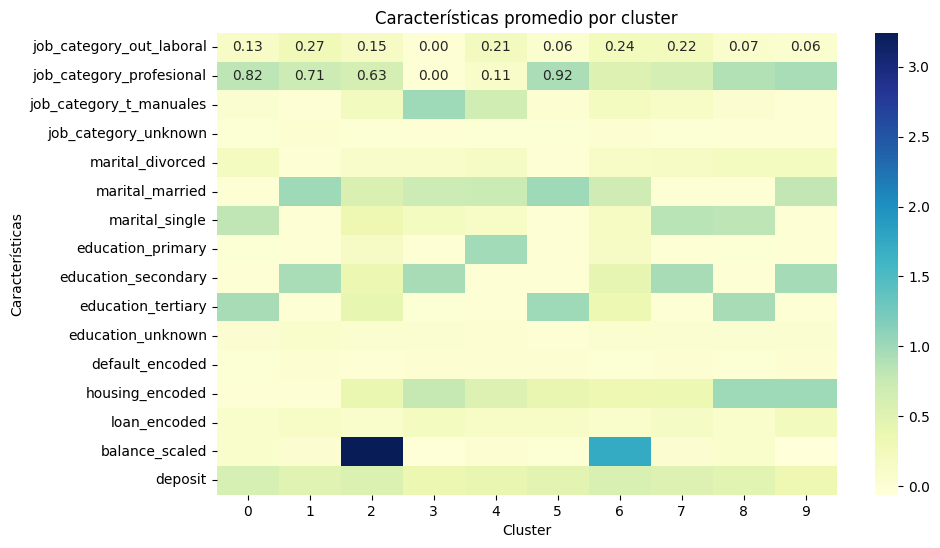

In [37]:
#Visualizar las estadísticas en un gráfico
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_stats.T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Características promedio por cluster")
plt.xlabel("Cluster")
plt.ylabel("Características")
plt.show()

Distribución de la variable objetivo ('deposit') por cluster:
deposit         0         1
cluster                    
0        0.397163  0.602837
1        0.512281  0.487719
2        0.454545  0.545455
3        0.624473  0.375527
4        0.588556  0.411444
5        0.540000  0.460000
6        0.427673  0.572327
7        0.469907  0.530093
8        0.526570  0.473430
9        0.672474  0.327526


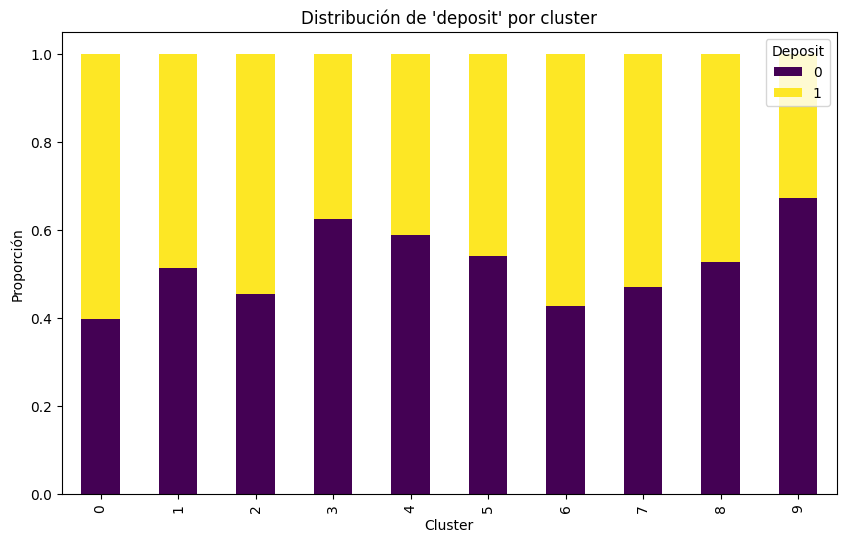

In [38]:
# Calcular la proporción de 'deposit' dentro de cada cluster
deposit_distribution = test_data.groupby('cluster')['deposit'].value_counts(normalize=True).unstack()

# Imprimir la distribución de la variable objetivo por cluster
print("Distribución de la variable objetivo ('deposit') por cluster:")
print(deposit_distribution)

# Visualizar la distribución de 'deposit' para cada cluster
deposit_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Distribución de 'deposit' por cluster")
plt.xlabel("Cluster")
plt.ylabel("Proporción")
plt.legend(title='Deposit', loc='upper right')
plt.show()

### Visualización de clusters (con PCA para 2D)

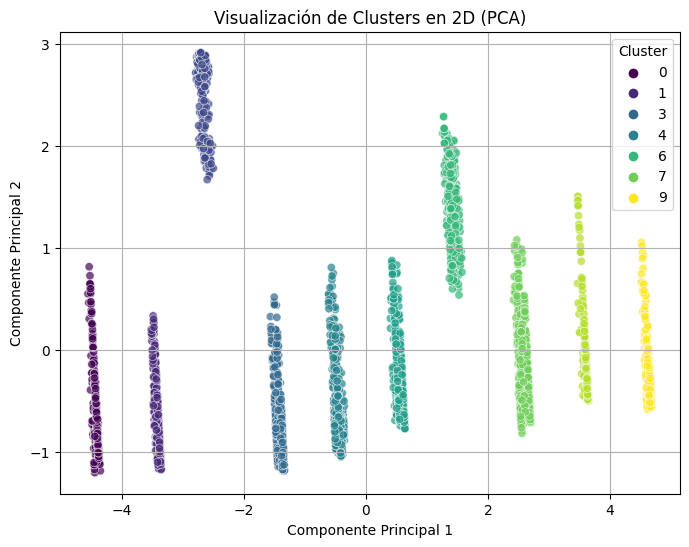

In [39]:
# Reducir las dimensiones a 2 componentes principales
pca2 = PCA(n_components=2)
X_test_pca = pca2.fit_transform(test_data)

# Añadir las etiquetas de clusters al conjunto reducido
test_data['pca1'] = X_test_pca[:, 0]
test_data['pca2'] = X_test_pca[:, 1]

# Visualizar los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='pca1', y='pca2', hue='cluster', palette='viridis', alpha=0.7)
plt.title("Visualización de Clusters en 2D (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster", loc='upper right')
plt.grid(True)
plt.show()

### Evaluación de la estabilidad

Distribución de clusters (entrenamiento):
cluster
1    0.819916
0    0.180084
Name: proportion, dtype: float64

Distribución de clusters (prueba):
cluster
3    0.141535
7    0.128994
5    0.119439
4    0.109585
6    0.094954
2    0.088683
9    0.085697
1    0.085100
0    0.084204
8    0.061809
Name: proportion, dtype: float64


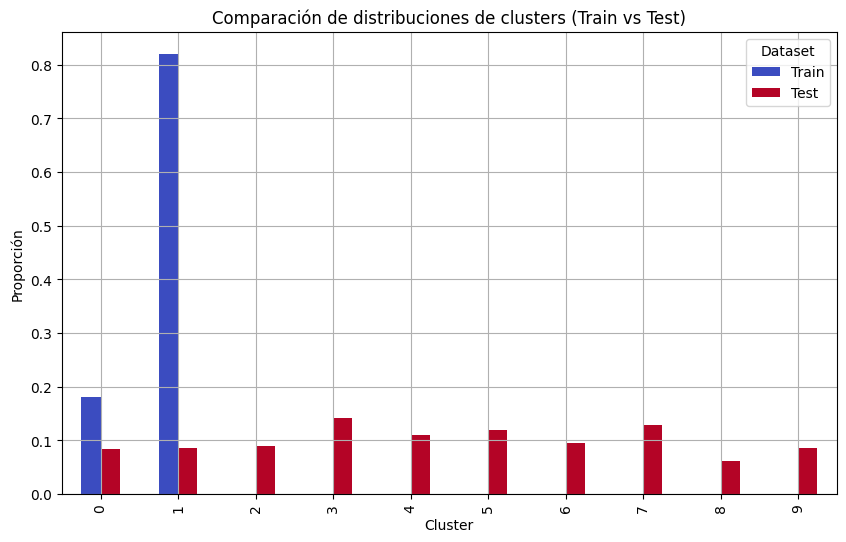

In [40]:
# Distribución de clusters en el conjunto de entrenamiento
train_cluster_dist = train_data['cluster'].value_counts(normalize=True)

# Distribución de clusters en el conjunto de prueba
test_cluster_dist = test_data['cluster'].value_counts(normalize=True)

# Comparar las distribuciones
print("Distribución de clusters (entrenamiento):")
print(train_cluster_dist)
print("\nDistribución de clusters (prueba):")
print(test_cluster_dist)

# Visualización comparativa
comparison_df = pd.DataFrame({
    'Train': train_cluster_dist,
    'Test': test_cluster_dist
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title("Comparación de distribuciones de clusters (Train vs Test)")
plt.xlabel("Cluster")
plt.ylabel("Proporción")
plt.legend(title="Dataset", loc='upper right')
plt.grid(True)
plt.show()

### Conclusiones del modelo en el dataset de test

Los resultados en el conjunto de prueba muestran un Silhouette Score bajo (0.2324), lo que indica que los clusters tienen una separación débil y cierta superposición entre ellos, lo que puede afectar la claridad de los segmentos. La inercia intra-clúster (18633.7510) sugiere que los datos dentro de cada cluster están razonablemente compactos.

La distribución de muestras entre los clusters está desequilibrada, con algunos clusters significativamente más pequeños (como el cluster 8 con 207 muestras) y otros más grandes (cluster 3 con 474 muestras). Esto podría reflejar segmentos de clientes minoritarios y mayoritarios.

En cuanto a la relación con la variable objetivo (deposit), algunos clusters muestran una mayor proporción de clientes que realizaron depósitos (por ejemplo, cluster 0 con el 60.28% y cluster 6 con el 57.23%), mientras que otros tienen tasas significativamente más bajas (como el cluster 9 con solo 32.75%). Estos resultados indican que ciertos clusters agrupan clientes con mayor propensión a realizar depósitos, lo que puede ser clave para diseñar campañas de marketing personalizadas y dirigidas a estos segmentos específicos para maximizar la conversión y el retorno de inversión.